In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# from sparktorch import serialize_torch_obj, SparkTorch, PysparkPipelineWrapper
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.functions as func
from pyspark.sql.types import *
# from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import constant
import tools

# 1.Methods
## load

In [2]:
def _load_parquet(path, schema:StructType = None):
    """
    load apache parquet file
    """
    return sqlContext.read.schema(schema).parquet(path) if schema is not None else sqlContext.read.parquet(path)

def _load_weather_toPandas(path):
    """
    load apache parquet file
    """
    return _load_parquet(path).toPandas()

def _load_csv(path, schema:StructType = None):
    """
    load csv file
    """
    if schema == None:
        return sqlContext.read.csv(path, sep=",", header=True, inferSchema="true")
    return sqlContext.read.csv(path, sep=",", header=True, schema=schema)


def load_files():
# to read parquet file
    settlement = _load_parquet(constant.settlement_201912_path, constant.settlement_schema_2)
    settlement = settlement.dropna(subset =["VAERDI"])
                # .withColumn("VAERDI", settlement["VAERDI"].cast("double"))
    
    # windmill = _load_csv(constant.windmill_test_path, constant.windmills_schema)
    windmill = _load_csv(constant.windmill_LW_600_path, constant.windmills_schema_2)
   
    wu10_dic = _load_weather_toPandas(constant.wu10_path)
    wv10_dic = _load_weather_toPandas(constant.wv10_path)
    wu100_dic = _load_weather_toPandas(constant.wu100_path)
    wv100_dic = _load_weather_toPandas(constant.wv100_path)
    tmp2_dic = _load_weather_toPandas(constant.tmp2_c_path)
    tmp100_dic = _load_weather_toPandas(constant.tmp100_c_path)
    tools.get_udf(wu10_dic, wv10_dic, wu100_dic, wv100_dic, tmp2_dic, tmp100_dic)

    return settlement, windmill

In [3]:
class NN(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
    self.d = nn.Dropout(p=0.3)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    # x = self.d(x)
    # x = F.relu(self.fc2(x))
    # x = self.d(x)
    x = self.fc3(x)

    return x

In [4]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # 128 + (26*2+3) = 183
    self.i20 = nn.Linear(input_size + hidden_size, output_size)
    # self.tanh = nn.Tanh(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1) # Concatenates
    hidden = self.i2h(combined)
    output = self.i20(combined)
    # output = self.tanh(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [5]:
class LSTM_Regression(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(LSTM_Regression, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [6]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [7]:
def train_model(
  model, 
  lr,
  num_epochs,
  X_train, 
  y_train, 
  X_test=None, 
  y_test=None
):
  loss_fn = torch.nn.MSELoss()

  optimiser = torch.optim.Adam(model.parameters(), lr=lr)
  num_epochs = num_epochs

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    # model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if X_test is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0 or t == num_epochs-1:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  
  return model.eval(), train_hist, test_hist

# 2.Analysis

In [8]:
# initialise sparkContext\
spark = SparkSession.builder \
        .master("local[4]") \
        .appName("WindTurbine_ws") \
        .config("spark.driver.memory","15g") \
        .config("spark.executor.memory","15g") \
        .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [9]:
settlement, windmill = load_files()
settlement.persist()
windmill.persist()

DataFrame[GSRN: string, Turbine_type: string, Placement: string, UTM_x: string, UTM_y: string, Capacity_kw: double, Rotor_diameter: double, Navhub_height: double, grid: string, Slope: double, Elevation: double, Roughness: double]

### Windmill Train and Test

In [ ]:
# windmill = windmill.sample(fraction=0.5, seed=1)

In [ ]:
timelist = settlement.select("TIME_CET")

In [ ]:
timelist = timelist.drop_duplicates()

In [ ]:
timelist = timelist.sample(fraction=0.05, seed=3)

In [ ]:
train = settlement.join(timelist, on="TIME_CET")

In [12]:
windmill.show(10)

+------------------+------------+---------+-----------------+-----------------+-----------+--------------+-------------+----+-----+---------+---------+
|              GSRN|Turbine_type|Placement|            UTM_x|            UTM_y|Capacity_kw|Rotor_diameter|Navhub_height|grid|Slope|Elevation|Roughness|
+------------------+------------+---------+-----------------+-----------------+-----------+--------------+-------------+----+-----+---------+---------+
|570714700000002786|           W|     LAND|         683346.0|        6136722.0|      600.0|          44.0|         45.0| 734|1.013|    25.03|      0.1|
|570714700000010361|           W|     LAND|       696808.488|       6077316.21|      600.0|          44.0|         45.0| 647|  0.0|     22.0|      0.1|
|570714700000010378|           W|     LAND|696813.2609999999|      6077122.971|      600.0|          44.0|         45.0| 647|1.013|     23.0|      0.1|
|570714700000010422|           W|     LAND|       642676.918|6092060.022999999|      600

In [27]:
windmill_train = windmill.where("GSRN != 570714700000010361")

In [28]:
# train = settlement.where("TIME_CET not like '2019-03-31 02%'").where("TIME_CET not like '2019-12-30%'").sample(fraction=0.001, seed=3)
train = settlement.where("TIME_CET not like '2019-12-30%'")
train = tools.interp_pow(train, windmill_train)

In [29]:
train.count()

50373

In [30]:
train.coalesce(1).write.save("data/single_train_interp.parquet", format="parquet")

In [ ]:
windmill.show(5)

In [22]:
windmill_LW_test =  windmill.where("GSRN == 570714700000010361")

In [23]:
test = settlement.where("TIME_CET like '2019-12-30%'")

In [24]:
test = tools.interp_pow(test, windmill_LW_test)

In [25]:
test.count()

24

In [26]:
test.coalesce(1).write.save("data/single_test_interp.parquet", format="parquet")

In [35]:
spark.stop()

# Train

In [50]:
train_pd = pd.read_parquet("data/single_train_interp.parquet")

In [51]:
train_pd = train_pd[train_pd["VAERDI"] > 100]

In [52]:
len(train_pd)

11372

In [53]:
test_pd = pd.read_parquet("data/single_test_interp.parquet")

In [54]:
test_pd = test_pd[test_pd["TIME_CET"].str.contains(":00:")]

In [55]:
# test_pd = test_pd[test_pd['TIME_CET'].str.contains(':00:')].sort_values(by='TIME_CET')
test_pd = test_pd.sort_values(by='TIME_CET')

## NN

In [56]:
feat_cols = ["u_interp", "v_interp", "tmp_interp","Rotor_diameter","Navhub_height","Slope","Elevation","Roughness"] 
# feat_cols = ["month", "hour", "Placement","Turbine_type", "Roughness", "Capacity_kw", "Rotor_diameter", "Navhub_height", "ws10", "ws100", "wd10", "wd100", "tmp2", "tmp100"]
x_train = train_pd[feat_cols]
y_train = train_pd[["VAERDI"]]
x_test = test_pd[feat_cols]
y_test = test_pd[["VAERDI"]]
timeline = test_pd[["TIME_CET"]]

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [58]:
dtype = torch.float
x_train_tensor = torch.tensor(x_train, dtype = dtype)
x_test_tensor = torch.tensor(x_test, dtype = dtype)
y_train_tensor = torch.tensor(y_train.values, dtype = dtype)
y_test_tensor = torch.tensor(y_test.values, dtype = dtype)

In [59]:
model = NN(
  input_size=8,
  hidden_size=1000,
  output_size=1
)
model, train_hist, test_hist = train_model(
  model, 
  0.1,
  100,
  x_train_tensor, 
  y_train_tensor, 
  x_test_tensor, 
  y_test_tensor
)

Epoch 0 train loss: 61697.6875 test loss: 185503.078125
Epoch 10 train loss: 21567.296875 test loss: 86361.4296875
Epoch 20 train loss: 19044.865234375 test loss: 37764.5390625
Epoch 30 train loss: 16940.87890625 test loss: 46898.37890625
Epoch 40 train loss: 16812.51171875 test loss: 54551.046875
Epoch 50 train loss: 16321.2841796875 test loss: 49448.72265625
Epoch 60 train loss: 15959.4990234375 test loss: 44098.92578125
Epoch 70 train loss: 15708.69921875 test loss: 40815.06640625
Epoch 80 train loss: 15498.90234375 test loss: 38394.91015625
Epoch 90 train loss: 15333.865234375 test loss: 36403.44921875
Epoch 99 train loss: 15220.216796875 test loss: 34839.73828125


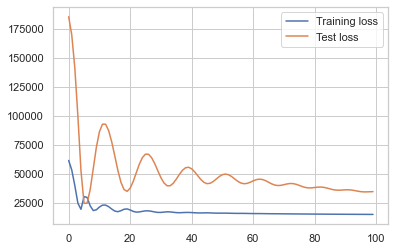

In [60]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()

In [61]:
y_pred_tensor = model(x_test_tensor)
y_pred = y_pred_tensor.detach().flatten().numpy()
y_test["pred"] = y_pred
y_test["time"] = pd.Series(timeline["TIME_CET"])
# y_test = y_test.groupby(y_test["time"]).agg({"VAERDI":lambda x:sum(x), "pred":lambda x:sum(x)}).reset_index()

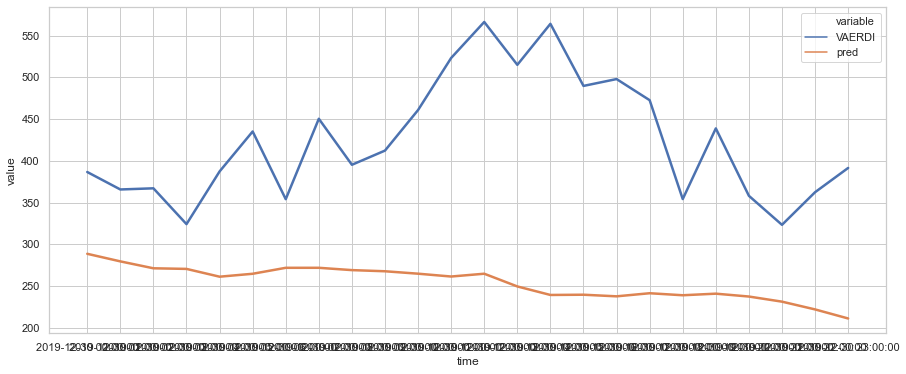

In [62]:
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(y_test, ['time']), hue='variable',linewidth=2.5)

## Clustering

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering, MeanShift
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from yellowbrick.cluster.elbow import kelbow_visualizer

In [ ]:
feat_cols = ["u_interp", "v_interp", "tmp_interp","Rotor_diameter","Navhub_height","Slope","Elevation","Roughness"]

In [ ]:
train_pd["Rotor_diameter"].plot.bar()

In [ ]:
train_pd["Navhub_height"].plot.bar()

In [ ]:
x_train = train_pd[feat_cols]
y_train = train_pd[["VAERDI"]]
x_test = test_pd[feat_cols]
y_test = test_pd[["VAERDI"]]
timeline = test_pd[["TIME_CET"]]

In [ ]:
def SpectralClustering_elbow(df,k=(2,10)):
    kelbow_visualizer(SpectralClustering(random_state=3, assign_labels='discretize'), df, k=k)

def SpectralClustering_simple(df, k):
    sc = SpectralClustering(random_state=3, assign_labels='discretize', n_clusters=k)
    cluster = sc.fit_predict(df)
    return cluster

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
SpectralClustering_elbow(x_train)

In [ ]:
x_train_cls = sc.predict(x_train)
x_test_cls = sc.predict(x_test)

In [ ]:
x_train_cls

In [ ]:
x_test_cls